In [460]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression

import joblib
import pickle


In [461]:
# Read in full dataset
df = pd.read_csv('./Resources/all_songs_final.csv')
df.head()

,song,artist,year,peak-rank,weeks-on-board,track_id,danceability,energy,key,loudness,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,billboard,decade
0,(1-2-3-4-5-6-7) Count The Days,Inez & Charlie Foxx,1968,76,5,4wXNtDvLZl55vlQashWQrI,0.686,0.562,5.0,-8.538,...,0.0504,0.589,0.000053,0.124,0.793,116.782,156886.0,4.0,1,1960s
1,(All Of A Sudden) My Heart Sings,Mel Carter,1965,38,7,6x5BiQwNlbtisITsEHa8Eu,0.419,0.546,7.0,-7.819,...,0.0363,0.479,0.000005,0.535,0.493,118.106,164067.0,3.0,1,1960s
2,(Baby) Hully Gully,The Olympics,1960,72,7,2CkbNJooPxUsHG4gFXKhxa,0.699,0.661,2.0,-6.090,...,0.0382,0.516,0.000000,0.198,0.869,115.772,218642.0,4.0,1,1960s
3,(Come round Here) Im The One You Need,The Miracles,1966,17,9,5YvokzRkNONpj5c0TIqTjQ,0.545,0.607,0.0,-9.525,...,0.0347,0.242,0.000000,0.779,0.767,113.880,150067.0,4.0,1,1960s
4,(Dance The) Mess Around,Chubby Checker,1961,24,7,58EirkLFB6O6wwRN9JowHB,0.511,0.694,10.0,-5.509,...,0.0479,0.381,0.000000,0.195,0.826,146.559,132933.0,4.0,1,1960s


In [462]:
# Show value counts for each decade (need to trim down more recent decades)
df.groupby(['decade', 'billboard'], as_index=False).count()[['decade', 'billboard', 'track_id']]

,decade,billboard,track_id
0,1960s,0,8655
1,1960s,1,6603
2,1970s,0,16880
3,1970s,1,5443
4,1980s,0,28190
5,1980s,1,4634
6,1990s,0,152689
7,1990s,1,4051
8,2000s,0,423393
9,2000s,1,4226


In [463]:
# Create separate dataframe for each decade
df1960s = df[df['decade']=='1960s']
df1970s = df[df['decade']=='1970s']
df1980s = df[df['decade']=='1980s']
df1990s = df[df['decade']=='1990s']
df2000s = df[df['decade']=='2000s']
df2010s = df[df['decade']=='2010s']


In [464]:
# Store current dataframe and check counts (change values here and run everything else)
df = df1970s
name = "1970s"
counter = Counter(df['billboard'])
counter

Counter({1: 5443, 0: 16880})

In [465]:
# Sample 15000 nonhits and check count
sampled_nonhits = df[df['billboard']==0].sample(10000)
counter = Counter(sampled_nonhits['billboard'])
counter

Counter({0: 10000})

In [466]:
# Recombine billboard songs and sample of non-charting songs
df = pd.concat([df[df['billboard']==1], sampled_nonhits])
counter = Counter(df['billboard'])
counter

Counter({1: 5443, 0: 10000})

In [467]:
# Select desired features from decade df
data = df[['danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms']]
data.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
6603,0.859,0.376,-16.542,0.0439,0.05360,0.096300,0.0605,0.902,127.202,450932.0
6604,0.406,0.597,-11.745,0.0336,0.07440,0.013300,0.2540,0.478,115.474,286813.0
6605,0.406,0.597,-11.745,0.0336,0.07440,0.013300,0.2540,0.478,115.474,286813.0
6606,0.611,0.292,-14.143,0.0281,0.06960,0.148000,0.0961,0.581,84.591,208287.0
6607,0.452,0.839,-4.705,0.0301,0.00281,0.000028,0.3000,0.636,124.724,204760.0


In [468]:
# Store labeled column as target
target = df["billboard"]
target_names = ["not_a_hit", "hit"]

In [469]:
# Split into training/testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [470]:
# Use SMOTE to oversample hits (OPTIONAL - not used for every one)
from imblearn.over_sampling import SMOTE

from collections import Counter

oversample = SMOTE(random_state=0, sampling_strategy=.9)
X_train, y_train = oversample.fit_resample(X_train, y_train)

counter = Counter(y_train)
counter

# X_res.value_counts()

Counter({1: 6772, 0: 7525})

In [471]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


# # Support vector machine linear classifier
from sklearn.svm import SVC 

modelsc = SVC(kernel='rbf', probability=True, class_weight='balanced')
# modelsc = LogisticRegression()
modelsc.fit(X_train_scaled, y_train)

# Model Accuracy
print('Scaled Test Acc: %.3f' % modelsc.score(X_test_scaled, y_test))

Scaled Test Acc: 0.658


In [439]:
# # create an iterator object with write permission - model.pkl
# with open(f'./ML_models/scaler_{name}', 'wb') as files:
#     pickle.dump(scaler, files)


# # create an iterator object with write permission - model.pkl
# with open(f'./ML_models/model_{name}', 'wb') as files:
#     pickle.dump(modelsc, files)

In [472]:
y_pred = modelsc.predict(X_test_scaled)
precision_score(y_test, y_pred)

0.5145283862315602

In [473]:
f1_score(y_test, y_pred)

0.6353850400220811

In [60]:
X_test_scaled.shape

14920      1
1137267    0
375100     0
1096021    0
803927     0
          ..
686190     0
12192      1
1134561    0
766712     0
173319     0
Name: billboard, Length: 8206, dtype: int64

In [151]:

# file name, I'm using *.joblib as a file extension
filename = "./ML_models/1980s_predictor.pickle"

# save model
joblib.dump(modelsc, filename)

# load model
loaded_model = joblib.load(filename)

test_song = [0.586,
 0.616,
#  5,
 -7.964,
#  1,
 0.0324,
 0.182,
 0,
 0.0927,
 0.719,
 148.088,
 242096]
# you can use loaded model to compute predictions
y_predicted = loaded_model.predict([test_song])

In [116]:
len(y_test)

5581

              precision    recall  f1-score   support

           0       0.86      0.56      0.68      2475
           1       0.51      0.83      0.64      1386

    accuracy                           0.66      3861
   macro avg       0.68      0.70      0.66      3861
weighted avg       0.73      0.66      0.66      3861



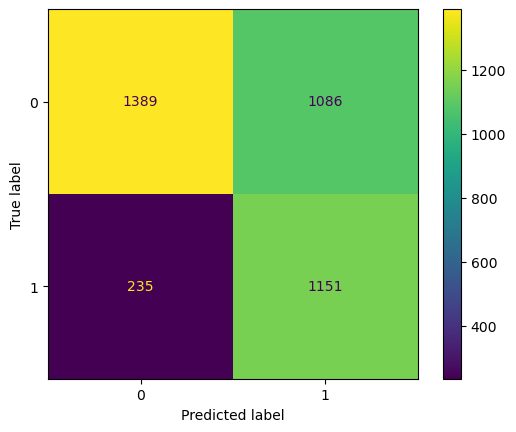

In [474]:
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(report)

ConfusionMatrixDisplay(cm).plot()

In [30]:
test_song = [0.586,
 0.616,
#  5,
 -7.964,
#  1,
 0.0324,
 0.182,
 0,
 0.0927,
 0.719,
 148.088,
 242096]

# modelsc.predict([test_song])

modelsc.predict([test_song])

array([0])

In [152]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [153]:
# Support vector machine linear classifier
from sklearn.svm import SVC 

modelsc = SVC(kernel='linear', probability=True)
modelsc.fit(X_train_scaled, y_train)

SVC(kernel='linear', probability=True)

Scaled Test Acc: 0.646
[[2281 1482]
 [ 326 1022]]
Precision: 0.40814696485623003


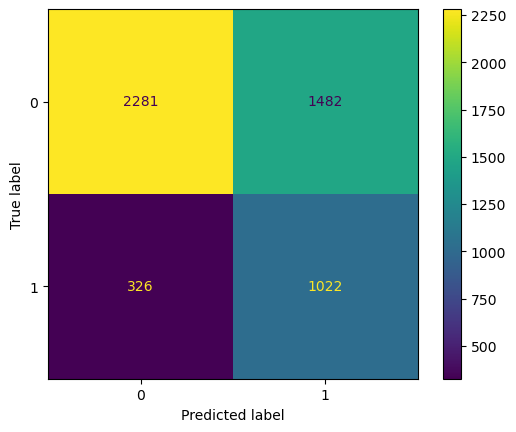

In [202]:
# Model Accuracy
print('Scaled Test Acc: %.3f' % modelsc.score(X_test_scaled, y_test))
y_true = y_test
y_predsc = modelsc.predict(X_test_scaled)
cm = confusion_matrix(y_true, y_predsc)

print(cm)
print("Precision:", precision_score(y_true, y_predsc))


ConfusionMatrixDisplay(cm).plot()

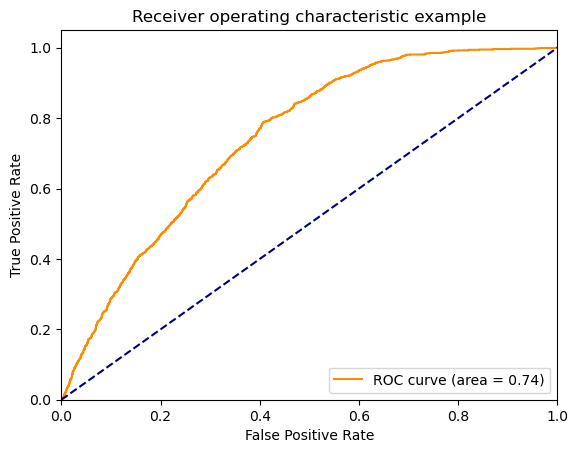

In [203]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc

y_pred_proba = modelsc.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [196]:
cm = confusion_matrix(y_test, y_pred)

TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

accuracy =  (TP+TN) /(TP+FP+TN+FN)

print('Accuracy of the binary classification = {:0.3f}'.format(accuracy))

True Positive(TP)  =  1121
False Positive(FP) =  1603
True Negative(TN)  =  2160
False Negative(FN) =  227
Accuracy of the binary classification = 0.642


In [91]:
from sklearn.metrics import f1_score, classification_report

report = classification_report(y_test, y_pred)
# precision_score(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.62      0.72      2151
           1       0.64      0.88      0.74      1664

    accuracy                           0.73      3815
   macro avg       0.75      0.75      0.73      3815
weighted avg       0.77      0.73      0.73      3815



In [2]:
def predict_decade(track_features, decade):
    
    file_path = "./ML_models/"
    model_names = {"1960s": "model_1960s",
                "1970s": "model_1970s",
                "1980s": "model_1980s",
                "1990s": "model_1990s",
                "2000s": "model_2000s",
                "2010s": "model_1970s"}
    
    scaler_names = {"1960s": "scaler_1960s",
                "1970s": "scaler_1970s",
                "1980s": "scaler_1980s",
                "1990s": "scaler_1990s",
                "2000s": "scaler_2000s",
                "2010s": "scaler_2010s"}

    # load model
    loaded_model = joblib.load(f"{file_path}{model_names[decade]}")
    loaded_scaler = joblib.load(f"{file_path}{scaler_names[decade]}")

    scaled_features = loaded_scaler.transform(track_features)

    # you can use loaded model to compute predictions
    y_predict = loaded_model.predict(scaled_features)
    y_pred_proba = loaded_model.predict_proba(scaled_features)

    if y_predict[0] == 1:
        billboard_prob = round(y_pred_proba[0][0], 3) * 100
        noncharting_prob = round(y_pred_proba[0][1],3) * 100
    else:
        billboard_prob = round(y_pred_proba[0][1], 3) * 100
        noncharting_prob = round(y_pred_proba[0][0],3) * 100

    
    print(f"Billboard Top 100: {billboard_prob}%\nNot Charting: {noncharting_prob}%")


In [5]:
test_song = [0.644,
 0.808,
 5,
 -7.268,
 1,
 0.0513,
 0.0467,
 0.187,
 0.0652,
 0.175,
 174.98,
 266507]


predict_decade([[0.369, 0.403, -7.996, 0.0259, 0.827, 0.0541, 0.106, 0.177, 154.899, 241917]], "1970s")

Billboard Top 100: 12.8%
Not Charting: 87.2%


/Users/glena.dagger/Downloads/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


In [13]:
modelsc.predict_proba([test_song])

NameError: name 'modelsc' is not defined